In [7]:
%%capture
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

In [8]:
%%capture
# install libraries
%pip install scikit-learn
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install tensorflow

# Change working directory to the project folder

In [9]:
%%capture
%cd /content/drive/My Drive/Assignment-3

# Task 1: CNN Implementation

1. Load the MNIST dataset.
2. Split train samples into 5-folds for cross-validation
3. Design and implement a CNN model using TensorFlow/Keras.
4. Train each fold
    - Preprocess the dataset: normalize the images, convert labels to one-hot vectors, etc.
    - Train the model on the training data and validate its performance on the validation data.
5. Report the test accuracy and loss.

### 1.1 Load MNIST dataset
The dataset is located in the subfolder (data)

In [10]:
%%capture
%pip install idx2numpy
import os
import idx2numpy            # original data is in ubyte format and idx2numpy converts into numpy

In [11]:
## Define data and model paths
data_dir = 'data'
SEED = 42

In [12]:
# load train and test images and convert into numpy
# Train
train_images = idx2numpy.convert_from_file(f'{data_dir}/train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file(f'{data_dir}/train-labels.idx1-ubyte')

# Test
test_images = idx2numpy.convert_from_file(f'{data_dir}/t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file(f'{data_dir}/t10k-labels.idx1-ubyte')

In [13]:
# inspect
print('Samples in the train dataset: ', train_images.shape[0])
print('Samples in the test dataset : ', test_images.shape[0])

Samples in the train dataset:  60000
Samples in the test dataset :  10000


### 1.2 Split train samples into 5-folds for cross-validation

In [14]:
## libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [15]:
## Arrange train samples in the dataframe and we will append kfold to it
df = pd.DataFrame(train_labels, columns = ['label'])
df.reset_index(inplace = True, drop = False)
df.head()

,index,label
0,0,5
1,1,0
2,2,4
3,3,1
4,4,9


In [16]:
## Split k-fold
# shuffle
df = df.sample(frac = 1, random_state = SEED).reset_index(drop = True)
df['kfold'] = -1

# split into multiple folds
kf = StratifiedKFold(n_splits=5)            # 5-folds

# populate the fold column
y = df['label']
for fold, (train_idx, valid_idx) in enumerate(kf.split(X=df, y=y), start = 1):
    df.loc[valid_idx, 'kfold'] = fold

df.sort_values(by = 'index', inplace = True, ascending = True)

# save the dataset
df.to_csv(f'{data_dir}/train_folds.csv')
df.head()

,index,label,kfold
22148,0,5,2
18420,1,0,2
48497,2,4,5
30804,3,1,3
5497,4,9,1


### 1.3 Design and implement a CNN model using TensorFlow/Keras.

In [17]:
## Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__)

2.14.0


In [18]:
# 3-layer CNN Model
def define_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))       # 10-classes
    return model

### 1.4 Train each fold

In [19]:
### Helper function to normalize and train a fold

def train(fold, results = []):

    ##### STEP 1: Extract fold data
    train_indices = df[df['kfold'] != fold]['index'].values.tolist()
    test_indices = df[df['kfold'] == fold]['index'].values.tolist()

    # Images
    trn_images = train_images[train_indices, :, :]
    tst_images = train_images[test_indices, :, :]

    # Labels
    trn_labels = df.loc[df['index'].isin(train_indices), 'label']
    tst_labels = df.loc[df['index'].isin(test_indices), 'label']

    ##### STEP 2: Normalize image pixels and apply ohe-hot-encoding to the labels
    # Image pixel normalization
    norm_trn_images = trn_images / 255.
    norm_tst_images = tst_images / 255.

    # One-hot-encode labels
    ohe_trn_labels = to_categorical(trn_labels)
    ohe_tst_labels = to_categorical(tst_labels)

    ##### STEP 3: Define model, complier, and earlystopping callback
    # instantiate model
    model = define_model()
    if fold == 1:
        # print model summary
        print(model.summary())

    # model complier
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Earlystopping callback
    early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)

    ##### STEP 4: Train model
    model.fit(norm_trn_images.reshape(-1, 28, 28, 1), ohe_trn_labels,
              validation_data = (norm_tst_images, ohe_tst_labels),
              epochs=20,
              batch_size=64,
              callbacks=[early_stopping])

    ##### STEP 5: Evaluate performance on both train and validation dataset
    train_loss, train_acc = model.evaluate(norm_trn_images, ohe_trn_labels)
    test_loss, test_acc = model.evaluate(norm_tst_images, ohe_tst_labels)
    results.append((fold, train_loss, train_acc, test_loss, test_acc))
    return results

In [20]:
results = []
for fold in range(1, 6):
    print(f'--- Training for fold {fold}----------------------------------')
    results = train(fold, results)
    print('\n' * 2)

--- Training for fold 1----------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                

In [21]:
### Cross-validation metrics
cv_df = pd.DataFrame(results, columns = ['fold', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'])
cv_df

,fold,train_loss,train_acc,valid_loss,valid_acc
0,1,0.010392,0.996750,0.031196,0.990333
1,2,0.013772,0.995812,0.035993,0.989583
2,3,0.010142,0.996604,0.035618,0.989250
3,4,0.012817,0.996042,0.034661,0.990333
4,5,0.011132,0.996417,0.036079,0.990000


In [22]:
average = cv_df['valid_acc'].mean()
std_dev = cv_df['valid_acc'].std()
print(f'5-fold, mean validation accuracy is {average:.4f} with stardard deviation {std_dev:.4f}')

5-fold, mean validation accuracy is 0.9899 with stardard deviation 0.0005


### 1.4 Report the test accuracy and loss.

In [23]:
################################################################################
# Train model with all the samples and parameters from the cross-validation
################################################################################

##### STEP 2: Normalize image pixels and apply ohe-hot-encoding to the labels
# Image pixel normalization
norm_train_images = train_images / 255.
norm_test_images = test_images / 255.

# One-hot-encode labels
ohe_train_labels = to_categorical(train_labels)
ohe_test_labels = to_categorical(test_labels)

##### STEP 3: Define model, complier, and earlystopping callback
# instantiate model
model = define_model()

# model complier
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Earlystopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                            patience=3,
                            restore_best_weights=True)

##### STEP 4: Train model
model.fit(norm_train_images.reshape(-1, 28, 28, 1), ohe_train_labels,
            epochs=9,
            batch_size=64)

Epoch 1/9
938/938 [==============================] - 8s 7ms/step - loss: 0.1832 - accuracy: 0.9435
Epoch 2/9
938/938 [==============================] - 5s 5ms/step - loss: 0.0540 - accuracy: 0.9833
Epoch 3/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0382 - accuracy: 0.9878
Epoch 4/9
938/938 [==============================] - 6s 7ms/step - loss: 0.0290 - accuracy: 0.9905
Epoch 5/9
938/938 [==============================] - 5s 6ms/step - loss: 0.0245 - accuracy: 0.9923
Epoch 6/9
938/938 [==============================] - 6s 7ms/step - loss: 0.0187 - accuracy: 0.9939
Epoch 7/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0159 - accuracy: 0.9946
Epoch 8/9
938/938 [==============================] - 5s 6ms/step - loss: 0.0138 - accuracy: 0.9955
Epoch 9/9
938/938 [==============================] - 6s 6ms/step - loss: 0.0128 - accuracy: 0.9957


In [24]:
##### STEP 5: Evaluate performance on both train and test dataset
train_loss, train_acc = model.evaluate(norm_train_images, ohe_train_labels)
test_loss, test_acc = model.evaluate(norm_test_images, ohe_test_labels)

print(f'Train accuracy  : {train_acc:.4f}')
print(f'Train loss      : {train_loss:.4f}')
print(f'Test accuracy   : {test_acc:.4f}')
print(f'Test loss       : {test_loss:.4f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0319 - accuracy: 0.9911
Train accuracy  : 0.9978
Train loss      : 0.0067
Test accuracy   : 0.9911
Test loss       : 0.0319


Test accuracy is 99.1% with crossentropy loss of 0.0319.

# Task 2: Visualization

In [25]:
### Libraries
import matplotlib.pyplot as plt
%matplotlib inline

1. Visualize the filters/kernels from the initial convolutional layers. What kind of features (e.g., edges, textures) can you infer from these visualizations?

In [26]:
## Model architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_5 (Flatten)         (None, 576)              

In [27]:
## Helper function for visualization
def plot_filters(conv1_weights, kernel_size):
    plt.figure(figsize=(10, 6))
    for i in range(kernel_size):
        ax = plt.subplot(4, 8, i + 1)
        filter_weights = conv1_weights[:, :, :, i]
        plt.imshow(filter_weights[:, :, 0], cmap='viridis')
        plt.axis('off')
        ax.set_title(f'filter {i}')
    plt.tight_layout()
    plt.show()

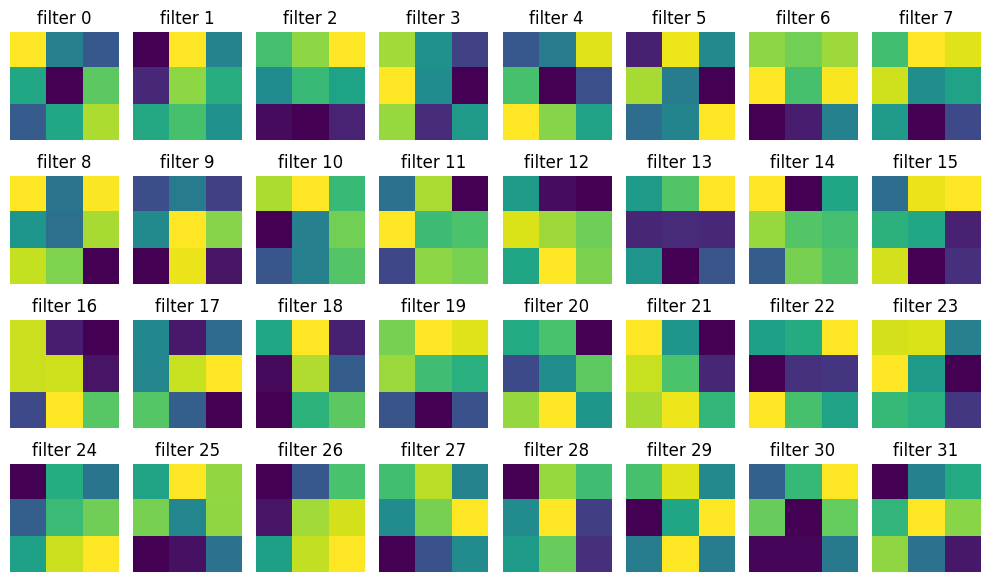

In [28]:
## Load initial layers
conv1_weights = model.layers[0].get_weights()[0]
plot_filters(conv1_weights, kernel_size = 32)

From the above images, we can infer that the each filter is designed to capture edges, curves, and simple textures from the images.
- The filters with highlighting the edges are trying to capture orientiation of the edges such as horizontal, veritical and diagonal (and the corresponding direction).
- The corner filters trys to identify regions where edges meet.
- These filtes also try to find pattern in the input images such as dots, dashes, and any repetations.
- These filters also try to find boundaries and shapes of the digits in the input images.

2. Use techniques like feature map visualization to see the activations produced by different convolutional and pooling layers for a given input image.

1/1 [==============================] - 0s 250ms/step

Layer name: conv2d_15


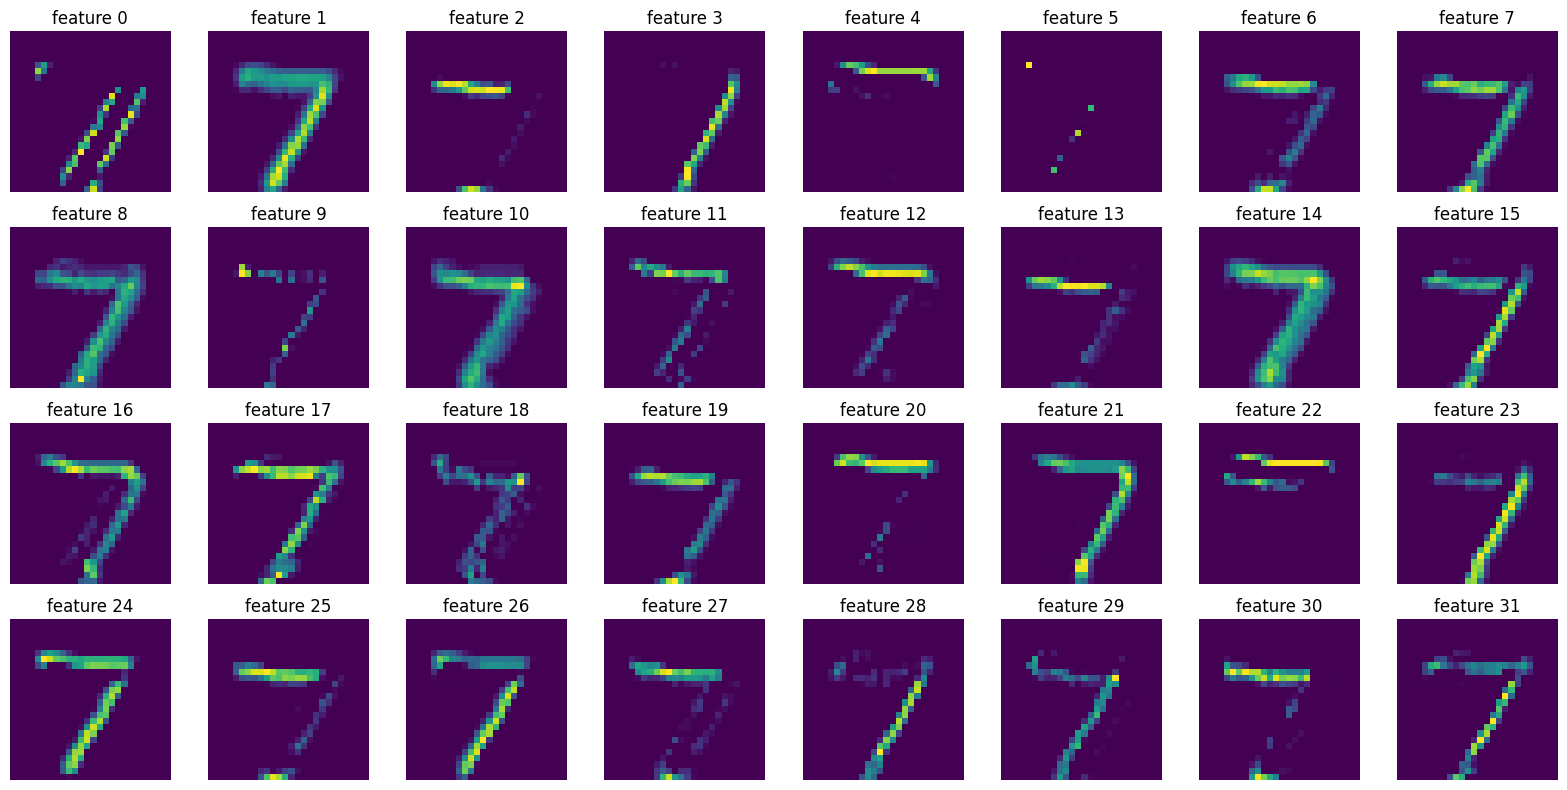


Layer name: max_pooling2d_10


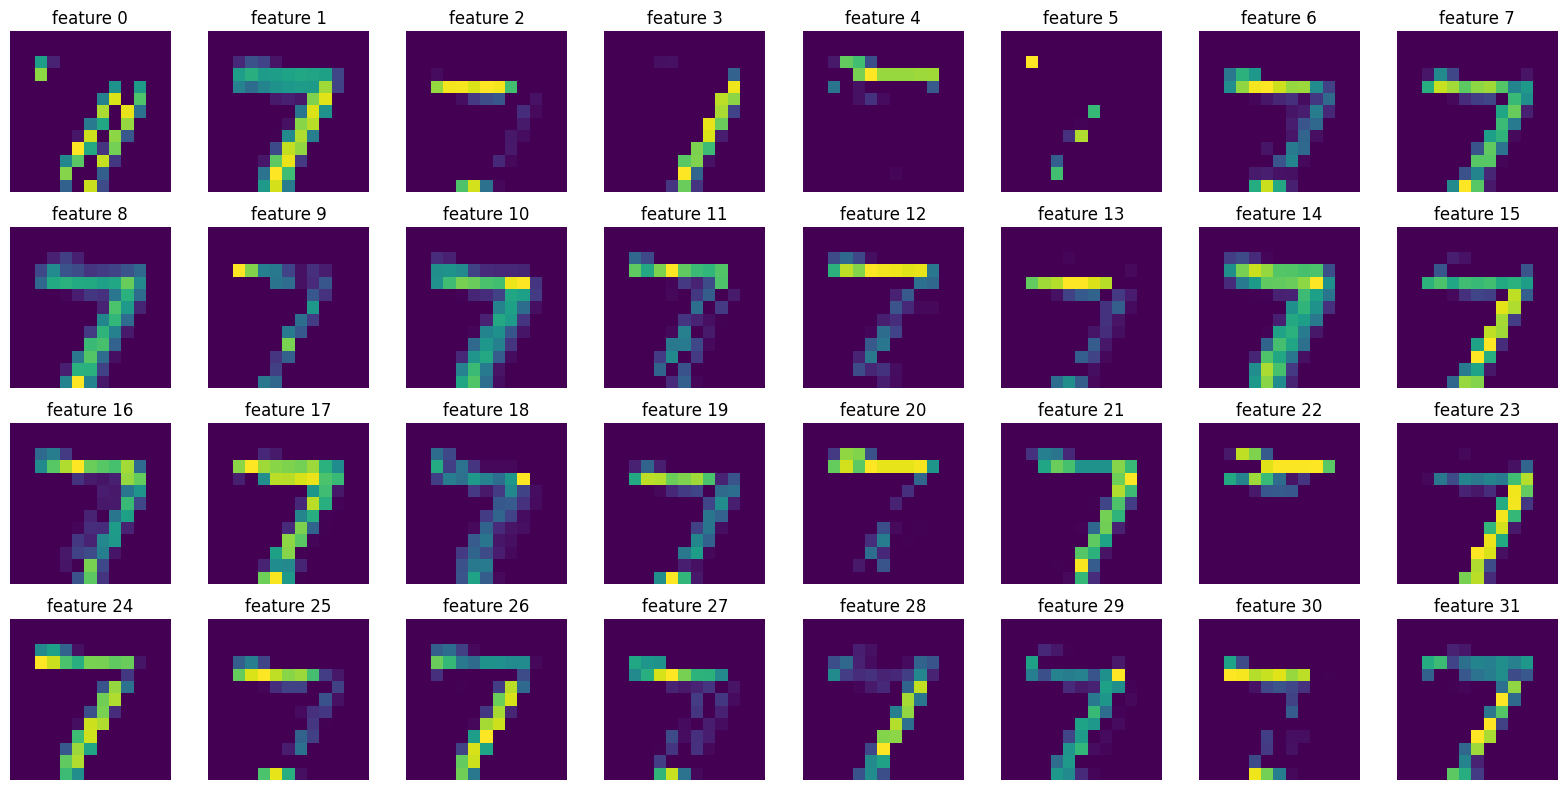


Layer name: conv2d_16


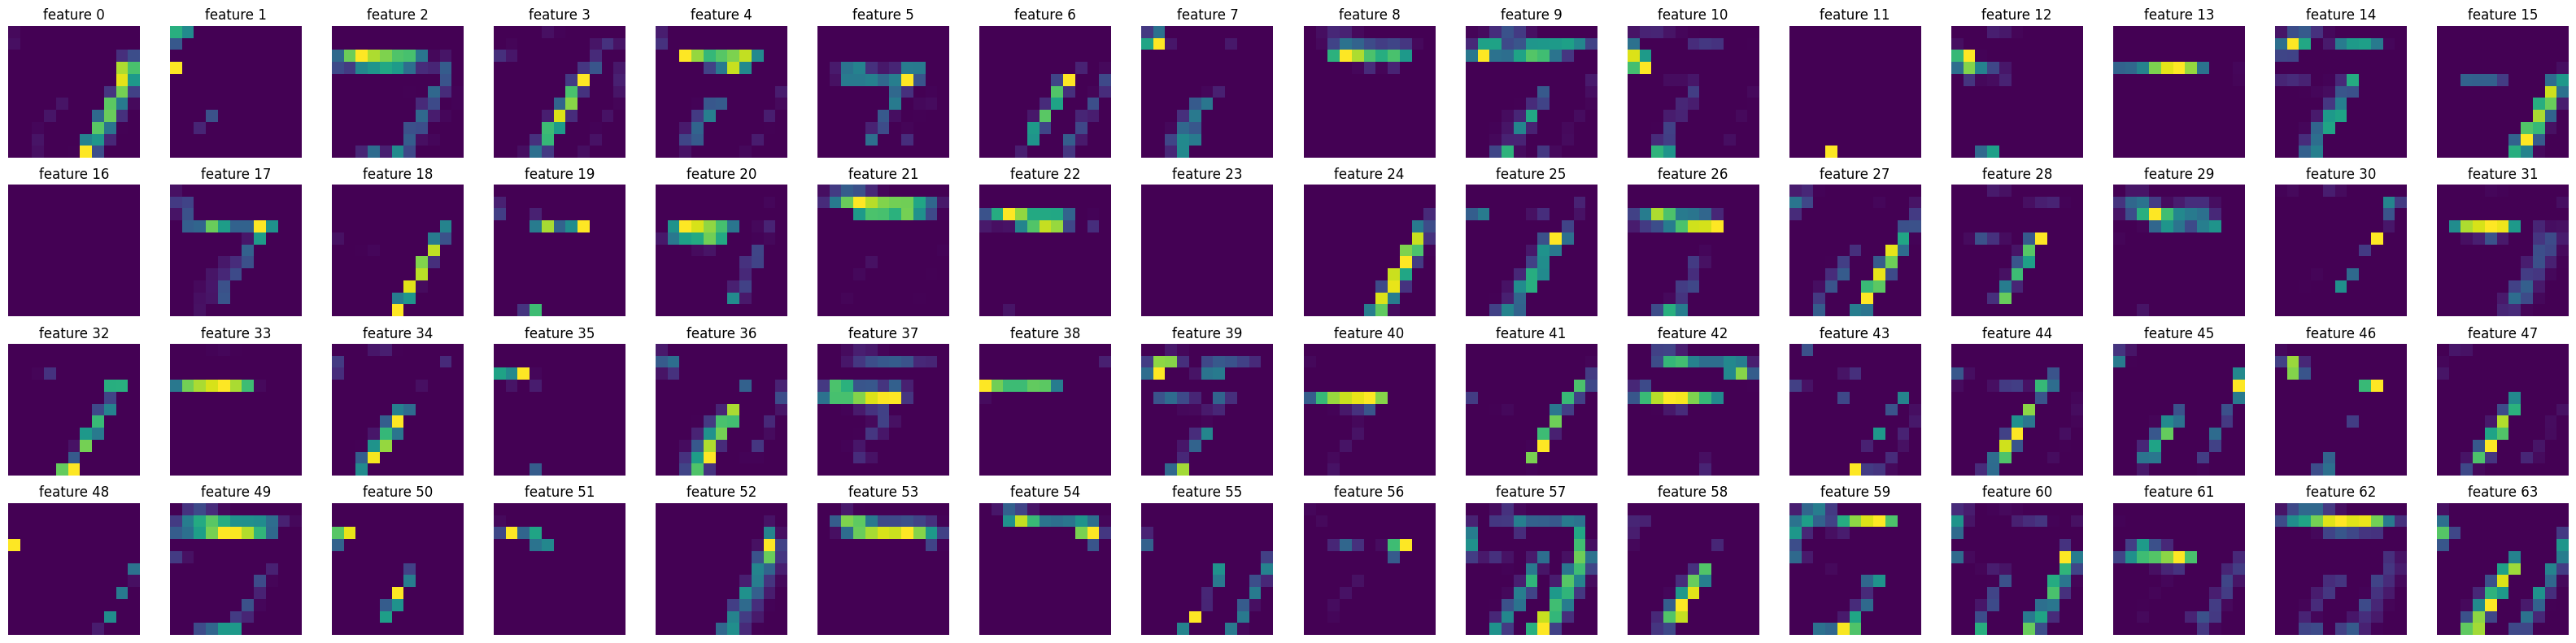


Layer name: max_pooling2d_11


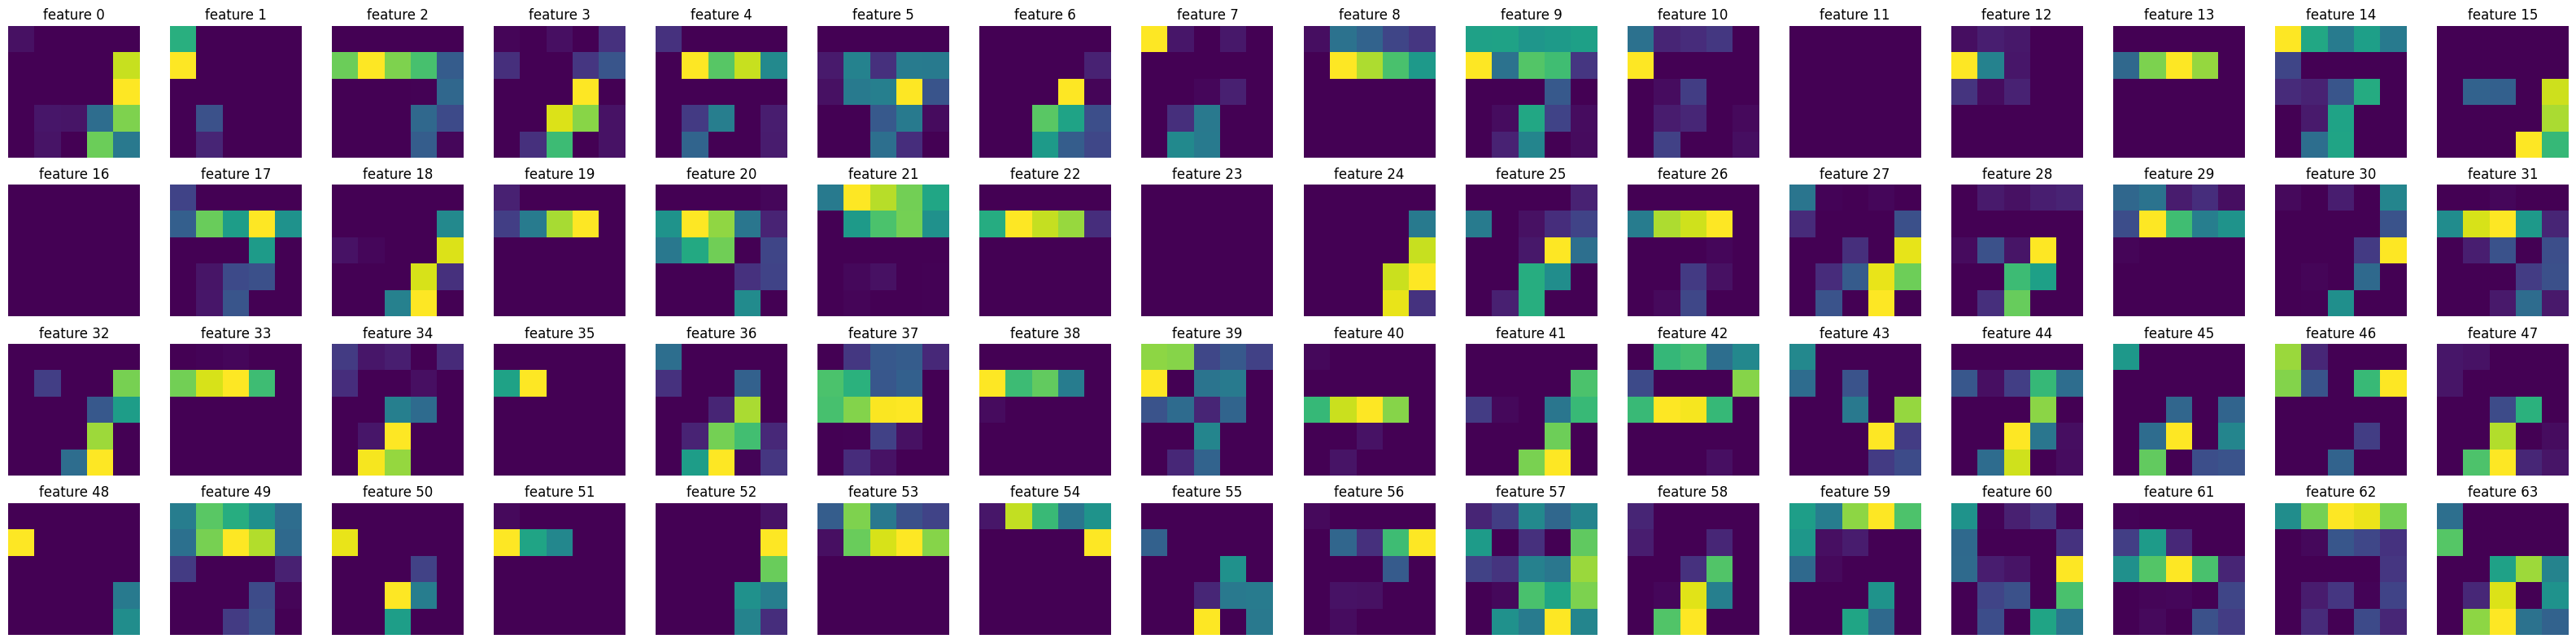


Layer name: conv2d_17


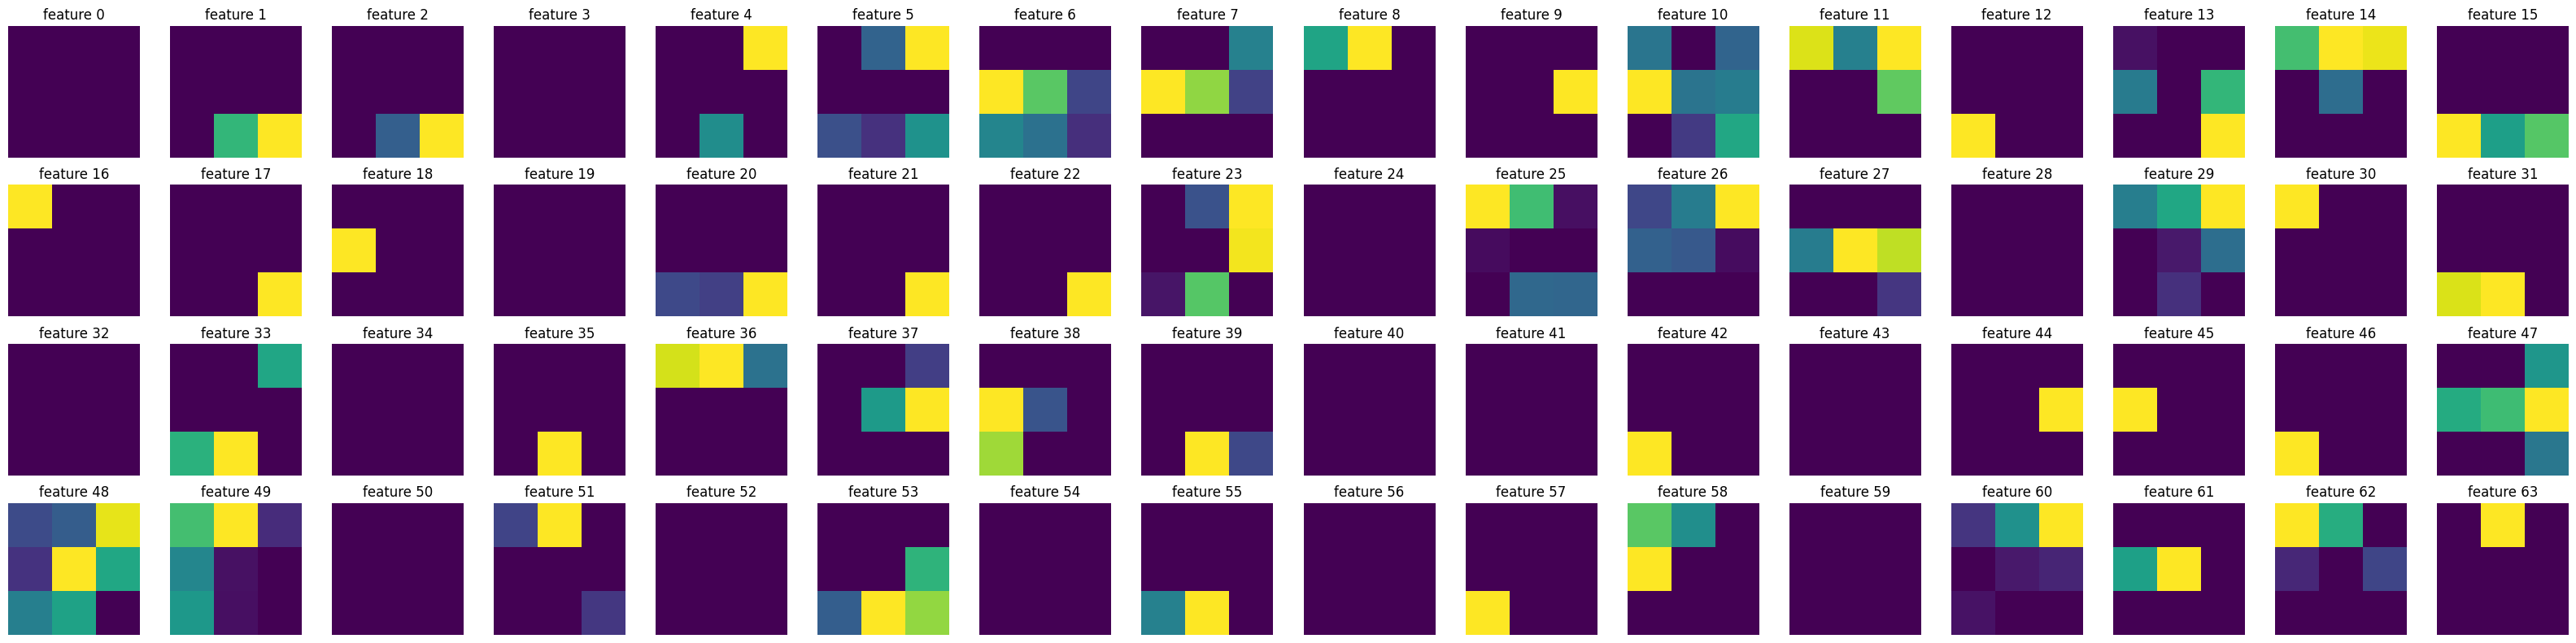

In [29]:
from tensorflow.keras.models import Model

# Choose a sample input image for visualization (you can use any image from the test set)
sample_image = test_images[0]

# Create a model to extract feature maps from intermediate layers
layer_outputs = [layer.output for layer in model.layers[:5]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps for the sample image
activations = activation_model.predict(np.expand_dims(sample_image, axis=0))

# Visualization of feature maps
layer_names = [layer.name for layer in model.layers[:5]]

for layer_name, layer_activation in zip(layer_names, activations):
    print('')
    print(f'Layer name: {layer_name}')
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    n_cols = n_features // 4
    n_rows = (n_features + n_cols - 1) // n_cols

    plt.figure(figsize=(2 * n_cols, 2 * n_rows))
    for i in range(n_features):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.title(f'feature {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## END